In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 2

In [4]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
ϕ_list  = np.load(f"v_list_{λ}.npy")
ems_list = np.load(f"e_list_{λ}.npy")

In [106]:
y1_grid_cap = np.arange(0., 2.+ y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.01
max_iter = 2_000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
ς = 0.01
Intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y1_mat_cap - 2)**2/(2*ς**2))*(y1_mat_cap <=2) + 1/(np.sqrt(2)*ς)*(y1_mat_cap>2)
# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][:loc_2+1]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 1. + ems_old * 0.
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.016049306438	 rhs error: 0.023555478417
Episode: 2	 lhs error: 0.008112157047	 rhs error: 0.021389771204
Episode: 3	 lhs error: 0.005119634616	 rhs error: 0.021316606973
Episode: 4	 lhs error: 0.005023539369	 rhs error: 0.021280482386
Episode: 5	 lhs error: 0.004932476200	 rhs error: 0.021245949741
Episode: 6	 lhs error: 0.004846610677	 rhs error: 0.021212831850
Episode: 7	 lhs error: 0.004765641998	 rhs error: 0.021181251817
Episode: 8	 lhs error: 0.004689258016	 rhs error: 0.021151235074
Episode: 9	 lhs error: 0.004617155227	 rhs error: 0.021122751594
Episode: 10	 lhs error: 0.004549044505	 rhs error: 0.021095741917
Episode: 11	 lhs error: 0.004484653785	 rhs error: 0.021070132362
Episode: 12	 lhs error: 0.004423728894	 rhs error: 0.021045843665
Episode: 13	 lhs error: 0.004366033387	 rhs error: 0.021022795831
Episode: 14	 lhs error: 0.004311347855	 rhs error: 0.021000910777
Episode: 15	 lhs error: 0.004259468983	 rhs error: 0.020980113710
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.003109930079	 rhs error: 0.020209734081
Episode: 126	 lhs error: 0.003109485557	 rhs error: 0.020205421281
Episode: 127	 lhs error: 0.003109034809	 rhs error: 0.020201129260
Episode: 128	 lhs error: 0.003108577874	 rhs error: 0.020196858167
Episode: 129	 lhs error: 0.003108114787	 rhs error: 0.020192608146
Episode: 130	 lhs error: 0.003107699452	 rhs error: 0.020188379342
Episode: 131	 lhs error: 0.003107302147	 rhs error: 0.020184171901
Episode: 132	 lhs error: 0.003106898154	 rhs error: 0.020179985964
Episode: 133	 lhs error: 0.003106487518	 rhs error: 0.020175821673
Episode: 134	 lhs error: 0.003106070282	 rhs error: 0.020171679168
Episode: 135	 lhs error: 0.003105681144	 rhs error: 0.020167558589
Episode: 136	 lhs error: 0.003105326007	 rhs error: 0.020163460072
Episode: 137	 lhs error: 0.003104963816	 rhs error: 0.020159383752
Episode: 138	 lhs error: 0.003104594622	 rhs error: 0.020155329763
Episode: 139	 lhs error: 0.003104218475	 rhs error: 0.02015129

Episode: 249	 lhs error: 0.003034451466	 rhs error: 0.019861129297
Episode: 250	 lhs error: 0.003033549174	 rhs error: 0.019859927541
Episode: 251	 lhs error: 0.003032642885	 rhs error: 0.019858751063
Episode: 252	 lhs error: 0.003031732616	 rhs error: 0.019857599824
Episode: 253	 lhs error: 0.003030818385	 rhs error: 0.019856473783
Episode: 254	 lhs error: 0.003029900208	 rhs error: 0.019855372900
Episode: 255	 lhs error: 0.003028978103	 rhs error: 0.019854297133
Episode: 256	 lhs error: 0.003028052086	 rhs error: 0.019853246440
Episode: 257	 lhs error: 0.003027122175	 rhs error: 0.019852220779
Episode: 258	 lhs error: 0.003026188386	 rhs error: 0.019851220107
Episode: 259	 lhs error: 0.003025250736	 rhs error: 0.019850244380
Episode: 260	 lhs error: 0.003024309241	 rhs error: 0.019849293556
Episode: 261	 lhs error: 0.003023363918	 rhs error: 0.019848367590
Episode: 262	 lhs error: 0.003022414783	 rhs error: 0.019847466437
Episode: 263	 lhs error: 0.003021461852	 rhs error: 0.01984659

Episode: 373	 lhs error: 0.002896624649	 rhs error: 0.019889720746
Episode: 374	 lhs error: 0.002895332911	 rhs error: 0.019891268714
Episode: 375	 lhs error: 0.002894038748	 rhs error: 0.019892835449
Episode: 376	 lhs error: 0.002892742171	 rhs error: 0.019894420898
Episode: 377	 lhs error: 0.002891443189	 rhs error: 0.019896025006
Episode: 378	 lhs error: 0.002890141811	 rhs error: 0.019897647719
Episode: 379	 lhs error: 0.002888838047	 rhs error: 0.019899288982
Episode: 380	 lhs error: 0.002887531908	 rhs error: 0.019900948742
Episode: 381	 lhs error: 0.002886223401	 rhs error: 0.019902626945
Episode: 382	 lhs error: 0.002884912538	 rhs error: 0.019904323536
Episode: 383	 lhs error: 0.002883599327	 rhs error: 0.019906038462
Episode: 384	 lhs error: 0.002882283778	 rhs error: 0.019907771668
Episode: 385	 lhs error: 0.002880965900	 rhs error: 0.019909523101
Episode: 386	 lhs error: 0.002879645702	 rhs error: 0.019911292708
Episode: 387	 lhs error: 0.002878323195	 rhs error: 0.01991308

Episode: 497	 lhs error: 0.002832662635	 rhs error: 0.020208643696
Episode: 498	 lhs error: 0.002832220217	 rhs error: 0.020212128564
Episode: 499	 lhs error: 0.002831776362	 rhs error: 0.020215626081
Episode: 500	 lhs error: 0.002831331070	 rhs error: 0.020219136201
Episode: 501	 lhs error: 0.002830884343	 rhs error: 0.020222658883
Episode: 502	 lhs error: 0.002830436180	 rhs error: 0.020226194081
Episode: 503	 lhs error: 0.002829986581	 rhs error: 0.020229741754
Episode: 504	 lhs error: 0.002829535546	 rhs error: 0.020233301857
Episode: 505	 lhs error: 0.002829083077	 rhs error: 0.020236874347
Episode: 506	 lhs error: 0.002828629173	 rhs error: 0.020240459181
Episode: 507	 lhs error: 0.002828173834	 rhs error: 0.020244056317
Episode: 508	 lhs error: 0.002827717062	 rhs error: 0.020247665710
Episode: 509	 lhs error: 0.002827258855	 rhs error: 0.020251287318
Episode: 510	 lhs error: 0.002826799215	 rhs error: 0.020254921098
Episode: 511	 lhs error: 0.002826338142	 rhs error: 0.02025856

Episode: 621	 lhs error: 0.002766994573	 rhs error: 0.020724499126
Episode: 622	 lhs error: 0.002766378194	 rhs error: 0.020729246348
Episode: 623	 lhs error: 0.002765760464	 rhs error: 0.020734001461
Episode: 624	 lhs error: 0.002765141383	 rhs error: 0.020738764432
Episode: 625	 lhs error: 0.002764520953	 rhs error: 0.020743535227
Episode: 626	 lhs error: 0.002763899175	 rhs error: 0.020748313813
Episode: 627	 lhs error: 0.002763276049	 rhs error: 0.020753100158
Episode: 628	 lhs error: 0.002762651578	 rhs error: 0.020757894228
Episode: 629	 lhs error: 0.002762025762	 rhs error: 0.020762695990
Episode: 630	 lhs error: 0.002761398601	 rhs error: 0.020767505412
Episode: 631	 lhs error: 0.002760770098	 rhs error: 0.020772322461
Episode: 632	 lhs error: 0.002760140254	 rhs error: 0.020777147105
Episode: 633	 lhs error: 0.002759509068	 rhs error: 0.020781979310
Episode: 634	 lhs error: 0.002758876544	 rhs error: 0.020786819044
Episode: 635	 lhs error: 0.002758242681	 rhs error: 0.02079166

Episode: 745	 lhs error: 0.002680633069	 rhs error: 0.021363707160
Episode: 746	 lhs error: 0.002679858677	 rhs error: 0.021369201790
Episode: 747	 lhs error: 0.002679083099	 rhs error: 0.021374700730
Episode: 748	 lhs error: 0.002678306337	 rhs error: 0.021380203957
Episode: 749	 lhs error: 0.002677528392	 rhs error: 0.021385711445
Episode: 750	 lhs error: 0.002676749266	 rhs error: 0.021391223171
Episode: 751	 lhs error: 0.002675968960	 rhs error: 0.021396739108
Episode: 752	 lhs error: 0.002675187476	 rhs error: 0.021402259234
Episode: 753	 lhs error: 0.002674404816	 rhs error: 0.021407783523
Episode: 754	 lhs error: 0.002673620981	 rhs error: 0.021413311952
Episode: 755	 lhs error: 0.002672835972	 rhs error: 0.021418844495
Episode: 756	 lhs error: 0.002672049792	 rhs error: 0.021424381128
Episode: 757	 lhs error: 0.002671262442	 rhs error: 0.021429921828
Episode: 758	 lhs error: 0.002670473923	 rhs error: 0.021435466570
Episode: 759	 lhs error: 0.002669684237	 rhs error: 0.02144101

Episode: 869	 lhs error: 0.002628558466	 rhs error: 0.022070790060
Episode: 870	 lhs error: 0.002628215169	 rhs error: 0.022076648420
Episode: 871	 lhs error: 0.002627871085	 rhs error: 0.022082508454
Episode: 872	 lhs error: 0.002627526212	 rhs error: 0.022088370143
Episode: 873	 lhs error: 0.002627180551	 rhs error: 0.022094233470
Episode: 874	 lhs error: 0.002626834102	 rhs error: 0.022100098416
Episode: 875	 lhs error: 0.002626486864	 rhs error: 0.022105964964
Episode: 876	 lhs error: 0.002626138837	 rhs error: 0.022111833096
Episode: 877	 lhs error: 0.002625790021	 rhs error: 0.022117702795
Episode: 878	 lhs error: 0.002625440416	 rhs error: 0.022123574041
Episode: 879	 lhs error: 0.002625090022	 rhs error: 0.022129446818
Episode: 880	 lhs error: 0.002624738838	 rhs error: 0.022135321109
Episode: 881	 lhs error: 0.002624386865	 rhs error: 0.022141196895
Episode: 882	 lhs error: 0.002624034101	 rhs error: 0.022147074159
Episode: 883	 lhs error: 0.002623680548	 rhs error: 0.02215295

Episode: 993	 lhs error: 0.002579948368	 rhs error: 0.022804832255
Episode: 994	 lhs error: 0.002579506776	 rhs error: 0.022810774779
Episode: 995	 lhs error: 0.002579064394	 rhs error: 0.022816717079
Episode: 996	 lhs error: 0.002578621221	 rhs error: 0.022822659142
Episode: 997	 lhs error: 0.002578177257	 rhs error: 0.022828600956
Episode: 998	 lhs error: 0.002577732503	 rhs error: 0.022834542508
Episode: 999	 lhs error: 0.002577286959	 rhs error: 0.022840483784
Episode: 1000	 lhs error: 0.002576840624	 rhs error: 0.022846424773
Episode: 1001	 lhs error: 0.002576393500	 rhs error: 0.022852365461
Episode: 1002	 lhs error: 0.002575945586	 rhs error: 0.022858305835
Episode: 1003	 lhs error: 0.002575496881	 rhs error: 0.022864245884
Episode: 1004	 lhs error: 0.002575047388	 rhs error: 0.022870185594
Episode: 1005	 lhs error: 0.002574597105	 rhs error: 0.022876124952
Episode: 1006	 lhs error: 0.002574146033	 rhs error: 0.022882063947
Episode: 1007	 lhs error: 0.002573694171	 rhs error: 0.

Episode: 1117	 lhs error: 0.002519223147	 rhs error: 0.023536310278
Episode: 1118	 lhs error: 0.002518685216	 rhs error: 0.023542137206
Episode: 1119	 lhs error: 0.002518146528	 rhs error: 0.023547962576
Episode: 1120	 lhs error: 0.002517607083	 rhs error: 0.023553786378
Episode: 1121	 lhs error: 0.002517066881	 rhs error: 0.023559608604
Episode: 1122	 lhs error: 0.002516525924	 rhs error: 0.023565429245
Episode: 1123	 lhs error: 0.002515984211	 rhs error: 0.023571248293
Episode: 1124	 lhs error: 0.002515441742	 rhs error: 0.023577065740
Episode: 1125	 lhs error: 0.002514898519	 rhs error: 0.023582881577
Episode: 1126	 lhs error: 0.002514354541	 rhs error: 0.023588695795
Episode: 1127	 lhs error: 0.002513809810	 rhs error: 0.023594508387
Episode: 1128	 lhs error: 0.002513264324	 rhs error: 0.023600319343
Episode: 1129	 lhs error: 0.002512718086	 rhs error: 0.023606128656
Episode: 1130	 lhs error: 0.002512171094	 rhs error: 0.023611936318
Episode: 1131	 lhs error: 0.002511623350	 rhs er

Episode: 1241	 lhs error: 0.002461363582	 rhs error: 0.024244557199
Episode: 1242	 lhs error: 0.002461092341	 rhs error: 0.024250133743
Episode: 1243	 lhs error: 0.002460820579	 rhs error: 0.024255707864
Episode: 1244	 lhs error: 0.002460548294	 rhs error: 0.024261279557
Episode: 1245	 lhs error: 0.002460275486	 rhs error: 0.024266848815
Episode: 1246	 lhs error: 0.002460002155	 rhs error: 0.024272415635
Episode: 1247	 lhs error: 0.002459728301	 rhs error: 0.024277980010
Episode: 1248	 lhs error: 0.002459453923	 rhs error: 0.024283541935
Episode: 1249	 lhs error: 0.002459179022	 rhs error: 0.024289101404
Episode: 1250	 lhs error: 0.002458903597	 rhs error: 0.024294658412
Episode: 1251	 lhs error: 0.002458627648	 rhs error: 0.024300212954
Episode: 1252	 lhs error: 0.002458351174	 rhs error: 0.024305765024
Episode: 1253	 lhs error: 0.002458074177	 rhs error: 0.024311314618
Episode: 1254	 lhs error: 0.002457796654	 rhs error: 0.024316861730
Episode: 1255	 lhs error: 0.002457518607	 rhs er

Episode: 1365	 lhs error: 0.002423692860	 rhs error: 0.024916059434
Episode: 1366	 lhs error: 0.002423355635	 rhs error: 0.024921299883
Episode: 1367	 lhs error: 0.002423017870	 rhs error: 0.024926537377
Episode: 1368	 lhs error: 0.002422679566	 rhs error: 0.024931771914
Episode: 1369	 lhs error: 0.002422340724	 rhs error: 0.024937003489
Episode: 1370	 lhs error: 0.002422001342	 rhs error: 0.024942232101
Episode: 1371	 lhs error: 0.002421661421	 rhs error: 0.024947457747
Episode: 1372	 lhs error: 0.002421320961	 rhs error: 0.024952680422
Episode: 1373	 lhs error: 0.002420979962	 rhs error: 0.024957900123
Episode: 1374	 lhs error: 0.002420638424	 rhs error: 0.024963116849
Episode: 1375	 lhs error: 0.002420296346	 rhs error: 0.024968330595
Episode: 1376	 lhs error: 0.002419953729	 rhs error: 0.024973541359
Episode: 1377	 lhs error: 0.002419610573	 rhs error: 0.024978749138
Episode: 1378	 lhs error: 0.002419266877	 rhs error: 0.024983953928
Episode: 1379	 lhs error: 0.002418922642	 rhs er

Episode: 1489	 lhs error: 0.002377760981	 rhs error: 0.025542503158
Episode: 1490	 lhs error: 0.002377356869	 rhs error: 0.025547357696
Episode: 1491	 lhs error: 0.002376952221	 rhs error: 0.025552208998
Episode: 1492	 lhs error: 0.002376547035	 rhs error: 0.025557057061
Episode: 1493	 lhs error: 0.002376141313	 rhs error: 0.025561901884
Episode: 1494	 lhs error: 0.002375735054	 rhs error: 0.025566743467
Episode: 1495	 lhs error: 0.002375328258	 rhs error: 0.025571581806
Episode: 1496	 lhs error: 0.002374920926	 rhs error: 0.025576416902
Episode: 1497	 lhs error: 0.002374513057	 rhs error: 0.025581248752
Episode: 1498	 lhs error: 0.002374104652	 rhs error: 0.025586077356
Episode: 1499	 lhs error: 0.002373695711	 rhs error: 0.025590902711
Episode: 1500	 lhs error: 0.002373286234	 rhs error: 0.025595724817
Episode: 1501	 lhs error: 0.002372876221	 rhs error: 0.025600543672
Episode: 1502	 lhs error: 0.002372465672	 rhs error: 0.025605359274
Episode: 1503	 lhs error: 0.002372054586	 rhs er

Episode: 1613	 lhs error: 0.002323593248	 rhs error: 0.026119432834
Episode: 1614	 lhs error: 0.002323123545	 rhs error: 0.026123878243
Episode: 1615	 lhs error: 0.002322653325	 rhs error: 0.026128320315
Episode: 1616	 lhs error: 0.002322182586	 rhs error: 0.026132759049
Episode: 1617	 lhs error: 0.002321711330	 rhs error: 0.026137194446
Episode: 1618	 lhs error: 0.002321239556	 rhs error: 0.026141626505
Episode: 1619	 lhs error: 0.002320767265	 rhs error: 0.026146055225
Episode: 1620	 lhs error: 0.002320294457	 rhs error: 0.026150480607
Episode: 1621	 lhs error: 0.002319821132	 rhs error: 0.026154902651
Episode: 1622	 lhs error: 0.002319347290	 rhs error: 0.026159321356
Episode: 1623	 lhs error: 0.002318872932	 rhs error: 0.026163736722
Episode: 1624	 lhs error: 0.002318398058	 rhs error: 0.026168148749
Episode: 1625	 lhs error: 0.002317922668	 rhs error: 0.026172557437
Episode: 1626	 lhs error: 0.002317446762	 rhs error: 0.026176962786
Episode: 1627	 lhs error: 0.002316970340	 rhs er

Episode: 1737	 lhs error: 0.002285809416	 rhs error: 0.026645217653
Episode: 1738	 lhs error: 0.002285539173	 rhs error: 0.026649249918
Episode: 1739	 lhs error: 0.002285268533	 rhs error: 0.026653278874
Episode: 1740	 lhs error: 0.002284997494	 rhs error: 0.026657304523
Episode: 1741	 lhs error: 0.002284726056	 rhs error: 0.026661326865
Episode: 1742	 lhs error: 0.002284454220	 rhs error: 0.026665345901
Episode: 1743	 lhs error: 0.002284181985	 rhs error: 0.026669361631
Episode: 1744	 lhs error: 0.002283909352	 rhs error: 0.026673374057
Episode: 1745	 lhs error: 0.002283636320	 rhs error: 0.026677383178
Episode: 1746	 lhs error: 0.002283362889	 rhs error: 0.026681388995
Episode: 1747	 lhs error: 0.002283089059	 rhs error: 0.026685391509
Episode: 1748	 lhs error: 0.002282814829	 rhs error: 0.026689390722
Episode: 1749	 lhs error: 0.002282540201	 rhs error: 0.026693386632
Episode: 1750	 lhs error: 0.002282265173	 rhs error: 0.026697379242
Episode: 1751	 lhs error: 0.002281989746	 rhs er

Episode: 1861	 lhs error: 0.002249237941	 rhs error: 0.027120239101
Episode: 1862	 lhs error: 0.002248917770	 rhs error: 0.027123867660
Episode: 1863	 lhs error: 0.002248597194	 rhs error: 0.027127493028
Episode: 1864	 lhs error: 0.002248276212	 rhs error: 0.027131115208
Episode: 1865	 lhs error: 0.002247954825	 rhs error: 0.027134734200
Episode: 1866	 lhs error: 0.002247633033	 rhs error: 0.027138350005
Episode: 1867	 lhs error: 0.002247310835	 rhs error: 0.027141962625
Episode: 1868	 lhs error: 0.002246988232	 rhs error: 0.027145572061
Episode: 1869	 lhs error: 0.002246665223	 rhs error: 0.027149178314
Episode: 1870	 lhs error: 0.002246341809	 rhs error: 0.027152781386
Episode: 1871	 lhs error: 0.002246017989	 rhs error: 0.027156381277
Episode: 1872	 lhs error: 0.002245693764	 rhs error: 0.027159977989
Episode: 1873	 lhs error: 0.002245369134	 rhs error: 0.027163571523
Episode: 1874	 lhs error: 0.002245044098	 rhs error: 0.027167161881
Episode: 1875	 lhs error: 0.002244718656	 rhs er

Episode: 1985	 lhs error: 0.002206446961	 rhs error: 0.027546263060
Episode: 1986	 lhs error: 0.002206076615	 rhs error: 0.027549506391
Episode: 1987	 lhs error: 0.002205705867	 rhs error: 0.027552746708
Episode: 1988	 lhs error: 0.002205334717	 rhs error: 0.027555984012
Episode: 1989	 lhs error: 0.002204963165	 rhs error: 0.027559218305
Episode: 1990	 lhs error: 0.002204591210	 rhs error: 0.027562449588
Episode: 1991	 lhs error: 0.002204218854	 rhs error: 0.027565677864
Episode: 1992	 lhs error: 0.002203846096	 rhs error: 0.027568903134
Episode: 1993	 lhs error: 0.002203472936	 rhs error: 0.027572125399
Episode: 1994	 lhs error: 0.002203099375	 rhs error: 0.027575344661
Episode: 1995	 lhs error: 0.002202725412	 rhs error: 0.027578560921
Episode: 1996	 lhs error: 0.002202351047	 rhs error: 0.027581774182
Episode: 1997	 lhs error: 0.002201976281	 rhs error: 0.027584984444
Episode: 1998	 lhs error: 0.002201601113	 rhs error: 0.027588191710
Episode: 1999	 lhs error: 0.002201225544	 rhs er

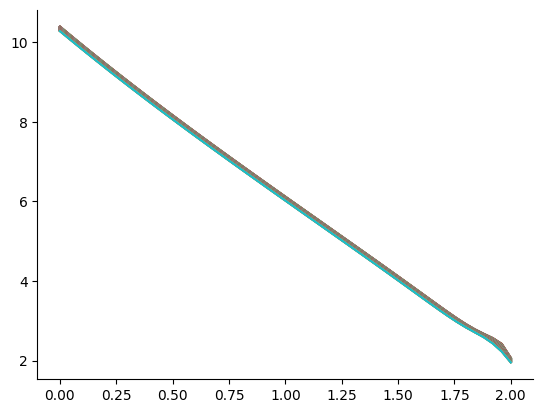

In [107]:
plt.plot(y1_grid_cap, ems)
plt.show()

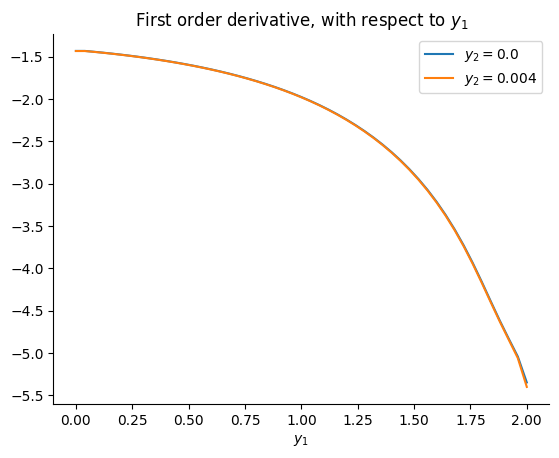

In [108]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

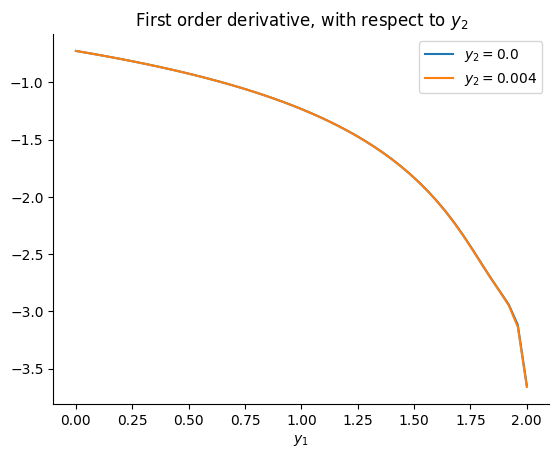

In [109]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

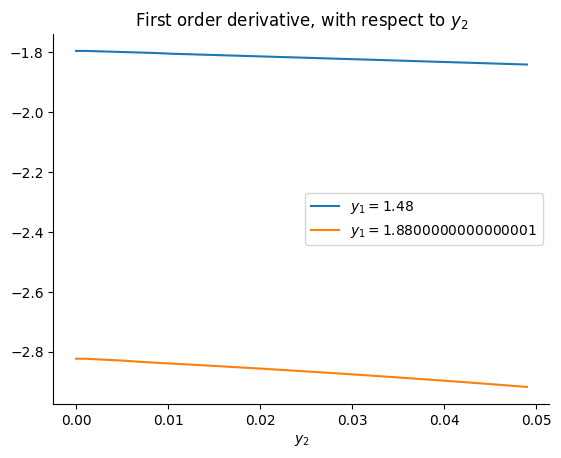

In [110]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

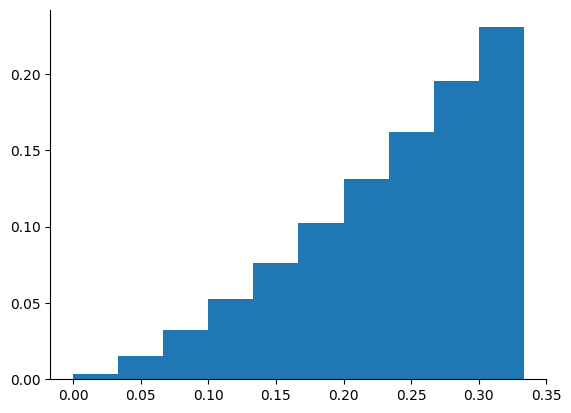

In [111]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

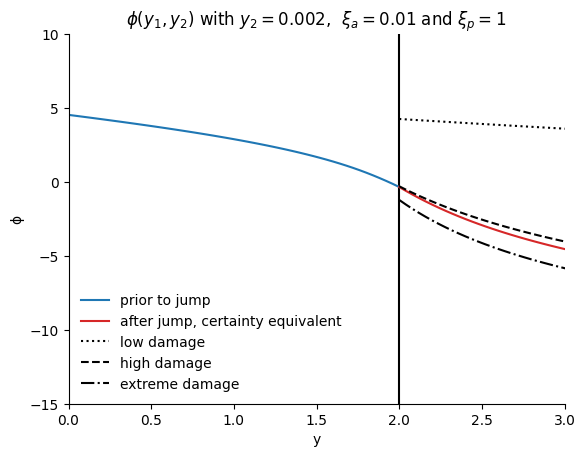

In [112]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

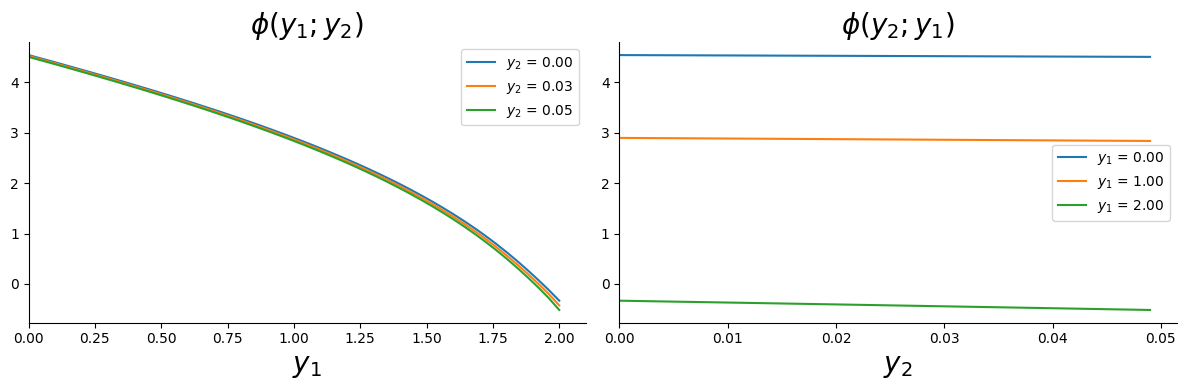

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

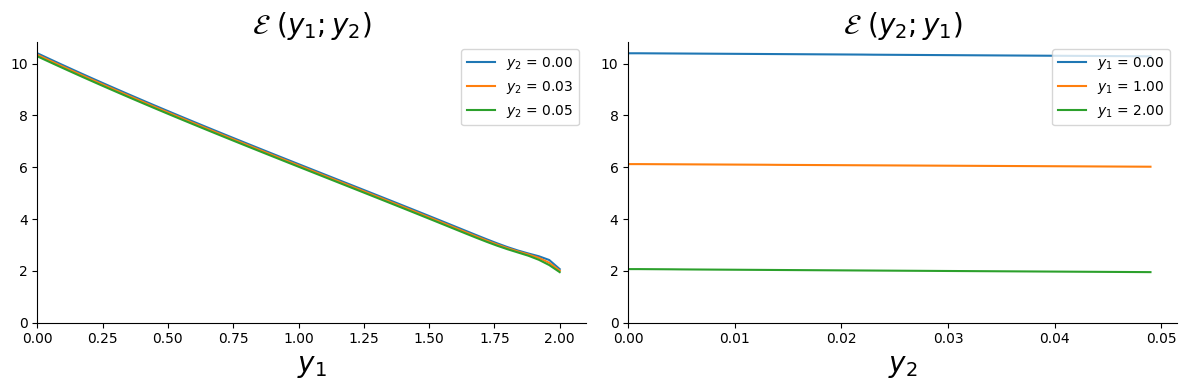

In [114]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [115]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [116]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [117]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [120]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [87]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

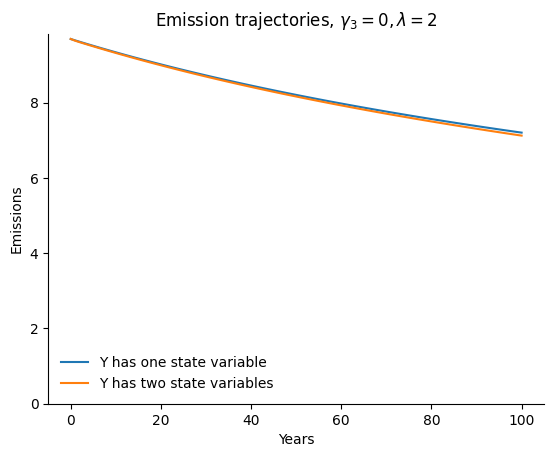

In [88]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [89]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=100
                                                 )

In [90]:
y1t_prejump

array([1.1       , 1.10953514, 1.12002213, 1.13056749, 1.14105286,
       1.15146303, 1.16179647, 1.17205348, 1.18223463, 1.19234048,
       1.20237159, 1.21232852, 1.22221178, 1.23202193, 1.2417595 ,
       1.251425  , 1.26101885, 1.27054157, 1.27999368, 1.28937572,
       1.29868816, 1.30793151, 1.31710629, 1.326213  , 1.33525208,
       1.34422401, 1.35312926, 1.36196833, 1.37074165, 1.37944954,
       1.38809248, 1.39667095, 1.40518543, 1.41363633, 1.42202406,
       1.43034909, 1.4386119 , 1.44681295, 1.45495255, 1.46303112,
       1.47104911, 1.47900697, 1.48690515, 1.49474385, 1.50252347,
       1.51024443, 1.51790719, 1.52551219, 1.53305972, 1.54055017,
       1.54798394, 1.55536146, 1.56268318, 1.56994941, 1.57716042,
       1.5843166 , 1.59141837, 1.59846615, 1.60546034, 1.61240111,
       1.61928877, 1.6261237 , 1.63290633, 1.63963704, 1.64631624,
       1.65294409, 1.65952097, 1.66604724, 1.6725233 , 1.67894954,
       1.68532634, 1.69165383, 1.6979323 , 1.70416214, 1.71034

In [39]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

# pickle.dump(simul, open(f"simul_{λ}_old", "wb"))

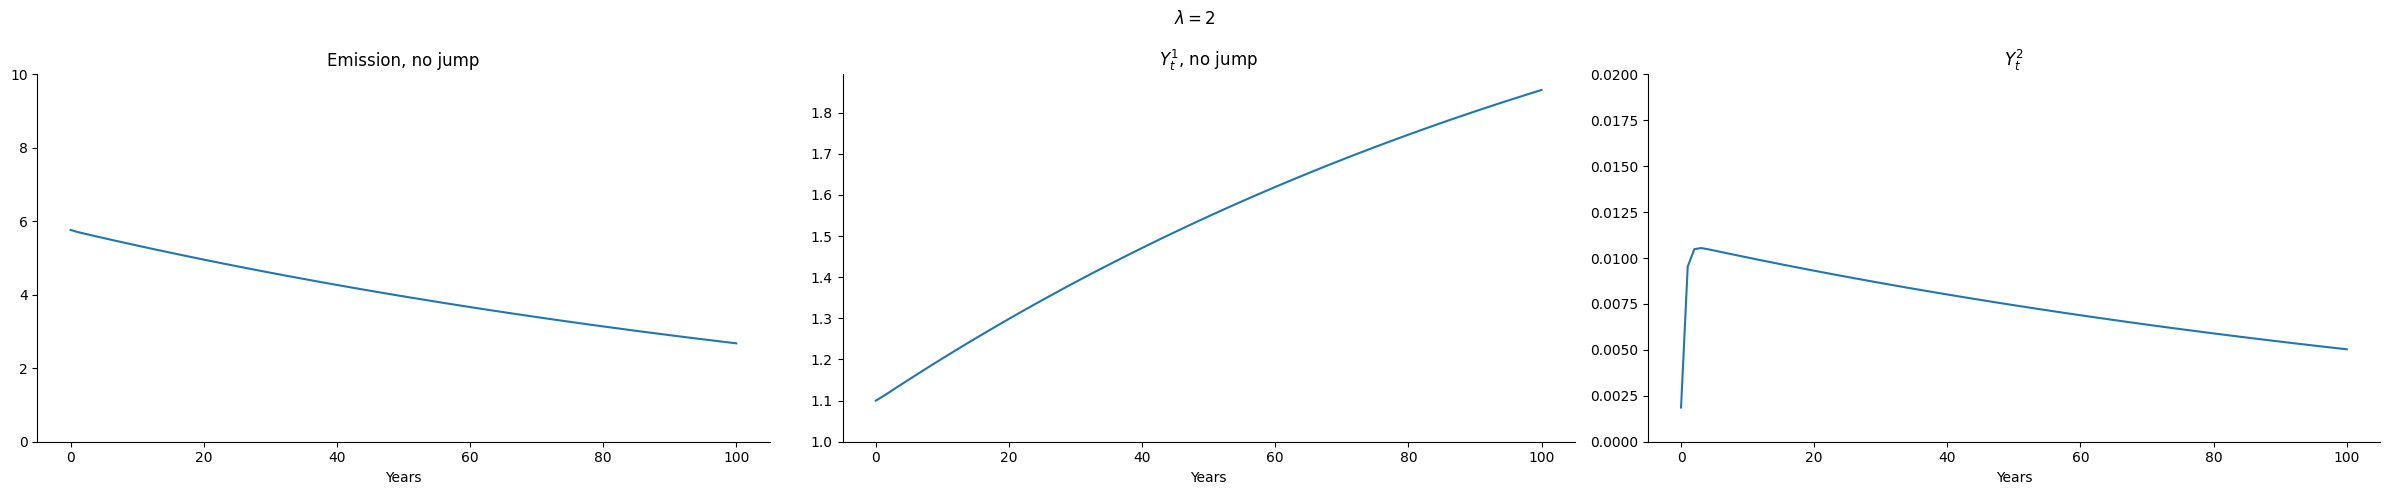

In [91]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [92]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [93]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.010545355026219082,
 0.049,
 array([1.1       , 1.10953514, 1.12002213, 1.13056749, 1.14105286,
        1.15146303, 1.16179647, 1.17205348, 1.18223463, 1.19234048,
        1.20237159, 1.21232852, 1.22221178, 1.23202193, 1.2417595 ,
        1.251425  , 1.26101885, 1.27054157, 1.27999368, 1.28937572,
        1.29868816, 1.30793151, 1.31710629, 1.326213  , 1.33525208,
        1.34422401, 1.35312926, 1.36196833, 1.37074165, 1.37944954,
        1.38809248, 1.39667095, 1.40518543, 1.41363633, 1.42202406,
        1.43034909, 1.4386119 , 1.44681295, 1.45495255, 1.46303112,
        1.47104911, 1.47900697, 1.48690515, 1.49474385, 1.50252347,
        1.51024443, 1.51790719, 1.52551219, 1.53305972, 1.54055017,
        1.54798394, 1.55536146, 1.56268318, 1.56994941, 1.57716042,
        1.5843166 , 1.59141837, 1.59846615, 1.60546034, 1.61240111,
        1.61928877, 1.6261237 , 1.63290633, 1.63963704, 1.64631624,
        1.65294409, 1.65952097, 1.66604724, 1.6725233 , 1.67894954,
        1.6853263

In [123]:
et, yt1 = simulation_1d(np.arange(0, 2 + 0.01,  0.01), np.load("ems_1state_prejump.npy"), θ=np.mean(θ_list), y_0=1.1)

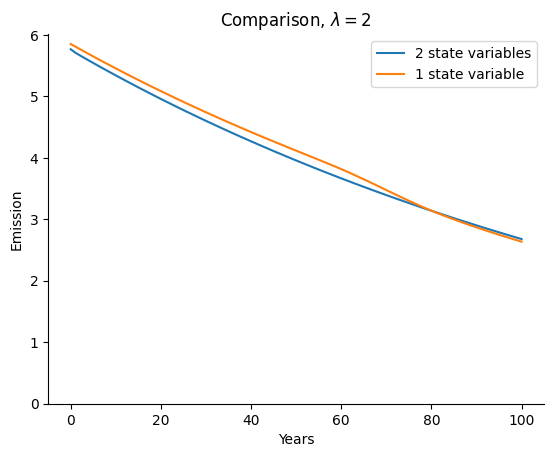

In [124]:
et_1state = np.load("et_1state_old.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [44]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [45]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [48]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=101)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

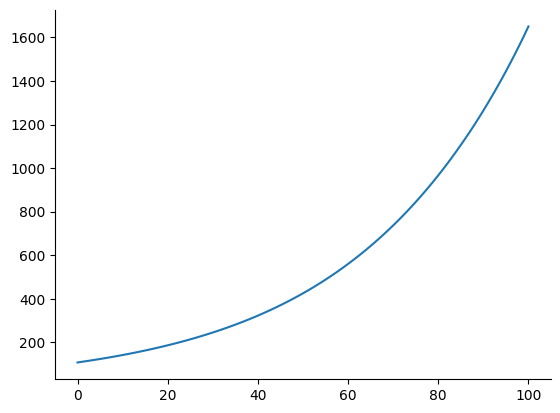

In [49]:
plt.plot(scc)
plt.show()